In [1]:
#export
import k1lib as _k1lib
import matplotlib.pyplot as _plt

In [2]:
#export
class PlotDecorator:
    def __init__(self, sliceablePlot, name):
        self.sliceablePlot = sliceablePlot
        self.name = name
        self.args, self.kwargs = None, None
    def __call__(self, *args, **kwargs):
        self.args = args; self.kwargs = kwargs
        return self.sliceablePlot
    def run(self):
        getattr(_plt, self.name)(*self.args, **self.kwargs)

In [3]:
#export
class SliceablePlot:
    def __init__(self, plotF, slices=[slice(None, None, None)], alphaSlice=None, plotDecorators=[], docs=""):
        self.plotF = plotF
        self.slices = [slices] if type(slices) == slice else slices
        self.alphaSlice = alphaSlice # slice using list of strings or string
        self.docs = docs
        self.plotDecorators = list(plotDecorators)
    @property
    def squeezedSlices(self): return _k1lib.squeeze(self.slices)
    def __getattr__(self, attr):
        if attr.startswith("_"): raise AttributeError()
        dec = PlotDecorator(self, attr); self.plotDecorators.append(dec)
        return dec
    def __getitem__(self, idx):
        if type(idx) == slice:
            return SliceablePlot(self.plotF, [idx], self.alphaSlice, self.plotDecorators, self.docs)
        if type(idx) == tuple and all([type(elem) == slice for elem in idx]):
            return SliceablePlot(self.plotF, idx, self.alphaSlice, self.plotDecorators, self.docs)
        return SliceablePlot(self.plotF, self.squeezedSlices, idx, self.plotDecorators, self.docs)
    def __repr__(self):
        if self.alphaSlice == None: self.plotF(self.squeezedSlices)
        else: self.plotF(self.squeezedSlices, self.alphaSlice)
        for ax in _plt.gcf().get_axes():
            _plt.sca(ax)
            [decorator.run() for decorator in self.plotDecorators]
        _plt.show()
        return f"""Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt{self.docs}"""

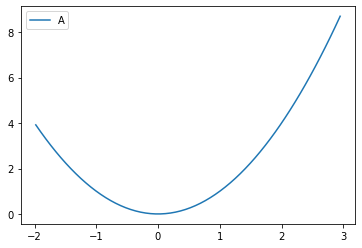

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [4]:
import numpy as np
def plotF(_slices):
    r = _k1lib.Range(-4, 4)
    if _slices == slice(None, None, None): _slices = r.slice
    ir = _k1lib.Range(100)
    x = np.linspace(*r, ir.stop)[r.toRange(ir, _slices).slice]
    y = x**2
    _plt.plot(x, y)
def plot():
    return SliceablePlot(plotF)
SliceablePlot(plotF).legend(["A"])[-2:3]

In [5]:
!../export.py viz

Current dir: /home/kelvin/repos/labs/k1lib, ../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 0.1.0
Uninstalling k1lib-0.1.0:
  Successfully uninstalled k1lib-0.1.0
running install
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing top-level names to k1lib.egg-info/top_level.txt
writing manifest file 'k1lib.egg-info/SOURCES.txt'
reading manifest file 'k1lib.egg-info/SOURCES.txt'
writing manifest file 'k1lib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/k1lib
copying k1lib/_learner.py -> build/lib/k1lib
copying k1lib/callbacks.py -> build/lib/k1lib
copying k1lib/data.py -> build/lib/k1lib
copying k1lib/imports.py -> build/lib/k1lib
copying k1lib/_basics.py -> build/lib/k1lib
copying k1lib/nn.py -> bui